In [3]:
% matplotlib inline
import bayleaf as bf
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
import theano
import theano.tensor as tt

In [3]:
# Test Copula Model
# Im
np.random.seed(57489402)
## Generated Dataset
import pandas as pd
n = 12000
β1 = np.array([1.63, 0.03])
β2 = np.array([0.8, 0.03])
#β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2])
λk = np.array([0.0047, 0.0037])
ρk = np.array([0.716, .725])
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)

X = sim_simple_covs(n)
exp_1 = np.exp(np.dot(X,βs.T))[:,0]
exp_2 = np.exp(np.dot(X,βs.T))[:,1]

α = 3.210
λ_s = λk[0]
ρ_s = ρk[0]
r_s =0.5

λ_t = λk[1]
ρ_t = ρk[1]
r_t =1.5

U_s = np.random.uniform(size=n)
S = ((U_s**(-r_s)-1)/(r_s*exp_1*λ_s))**(1/ρ_s)
U_t = np.random.uniform(size=n)
S_T = ((U_t**(-(α)/(α+1))-1)*(U_s)**(-α)+1)**(-α**(-1))
T = ((S_T**(-r_t)-1)/(r_t*exp_2*λ_t))**(1/ρ_t)

Te = np.vstack([S,T]).T
cens_end = 7500
maxtime = 500
Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime

Cens = 1+cens_end*np.random.uniform(size = (n,2))
Cens[Cens>maxtime] = maxtime
results = np.repeat(0, n)
names_df = ["del"]
# loop over levels
for level in range(2):
    obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
    names_df = np.append(names_df, "time_"+str(level+1))
    delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
    names_df = np.append(names_df, "delta_"+str(level+1))
    results = np.vstack((results, obs_t))
    results = pd.DataFrame(np.vstack((results, delta)))
#
x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
names_df = np.append(names_df, x_names)
#names_df = np.append(names_df, "frailty") # now add frailty
out = pd.DataFrame(np.vstack((results, X.T)).T)
out.columns = names_df
out = out.iloc[:, out.columns!="del"]

time_1 = np.array(out["time_1"])
time_2 = np.array(out["time_2"])

δ_1 = np.array(out["delta_1"])
δ_2 = np.array(out["delta_2"])

τ1_full = theano.shared(np.array(out["time_1"])+0.,borrow=True)
τ2_full = theano.shared(np.array(out["time_2"])+0.,borrow=True)

δ1_full = theano.shared(np.array(out["delta_1"])+0., borrow = True)
δ2_full = theano.shared(np.array(out["delta_2"])+0., borrow = True)

X_full = theano.shared(X+0., borrow = True)

In [4]:
formula = "([time_1, time_2],[delta_1, delta_2])~X_1+X_2-1"

In [5]:
formula

'([time_1, time_2],[delta_1, delta_2])~X_1+X_2-1'

In [6]:
with bf.pm.Model() as test_run:
    bf.Copula(time_1 = τ1_full,
              time_2 = τ2_full,
              e_1 =δ1_full, 
              e_2 = δ2_full, 
              x=X_full, family = 'clayton_trans', labels = ["x1","x2"])
    MAP = bf.pm.find_MAP()


logp = -93,010, ||grad|| = 385.38: 100%|██████████| 546/546 [00:19<00:00, 28.06it/s] 


In [6]:
with bf.pm.Model() as test_run:
    bf.Copula.from_formula(formula = "([time_1, time_2],[delta_1, delta_2])~X_1+X_2-1", data = out, family = "clayton_trans")
    MAP = bf.pm.find_MAP()


logp = -93,010, ||grad|| = 26.467: 100%|██████████| 371/371 [00:08<00:00, 44.33it/s] 


In [7]:
MAP

{'X_1_1': array(1.68229907),
 'X_1_2': array(0.8220451),
 'X_2_1': array(0.03178442),
 'X_2_2': array(0.03230092),
 'alpha': array(3.2063563),
 'alpha_log__': array(1.16513518),
 'lam_1': array(0.00430183),
 'lam_1_log__': array(-5.44871446),
 'lam_2': array(0.00310613),
 'lam_2_log__': array(-5.77437822),
 'r_1': array(0.49608851),
 'r_1_log__': array(-0.70100093),
 'r_2': array(1.55537659),
 'r_2_log__': array(0.44171769),
 'rho_1': array(0.72147441),
 'rho_1_log__': array(-0.32645837),
 'rho_2': array(0.7490674),
 'rho_2_log__': array(-0.28892632)}

In [15]:
with test_run:
    trace = bf.pm.sample(2000, tune =1500, start =MAP)

100%|██████████| 3500/3500 [1:10:44<00:00,  1.21s/it]


In [17]:
results = round(pm.summary(trace),3)
print(results.to_latex(escape=False,column_format='cccccc',index=True,))


\begin{tabular}{cccccc}
\toprule
{} &   mean &     sd &  mc_error &  hpd_2.5 &  hpd_97.5 &     n_eff &   Rhat \\
\midrule
x1_1  &  1.686 &  0.035 &     0.001 &    1.622 &     1.756 &  1597.371 &  1.000 \\
x2_1  &  0.032 &  0.001 &     0.000 &    0.030 &     0.034 &  1739.013 &  1.000 \\
x1_2  &  0.826 &  0.040 &     0.001 &    0.748 &     0.905 &  2071.032 &  1.000 \\
x2_2  &  0.033 &  0.002 &     0.000 &    0.029 &     0.036 &  1749.652 &  1.000 \\
rho_1 &  0.723 &  0.011 &     0.000 &    0.701 &     0.742 &  1474.589 &  1.000 \\
lam_1 &  0.004 &  0.000 &     0.000 &    0.004 &     0.005 &  1342.057 &  1.000 \\
lam_2 &  0.003 &  0.000 &     0.000 &    0.002 &     0.004 &  1618.397 &  1.001 \\
alpha &  3.212 &  0.067 &     0.001 &    3.082 &     3.343 &  3267.176 &  1.000 \\
r_2   &  1.578 &  0.109 &     0.003 &    1.357 &     1.787 &  1621.922 &  1.003 \\
r_1   &  0.504 &  0.037 &     0.001 &    0.430 &     0.574 &  1813.504 &  1.000 \\
rho_2 &  0.752 &  0.015 &     0.000 &    0.720 &

In [36]:
minibatch_δ1 = pm.Minibatch(data = δ1_full.get_value(), batch_size = 7000)
minibatch_δ2 = pm.Minibatch(data = δ2_full.get_value(), batch_size = 7000)
minibatch_X = pm.Minibatch(data = X_full.get_value(), batch_size = 7000)
minibatch_τ1 = pm.Minibatch(data = τ1_full.get_value(), batch_size = 7000)
minibatch_τ2 = pm.Minibatch(data = τ2_full.get_value(), batch_size = 7000)

with bf.pm.Model() as test_run:
    bf.Copula(time_1 = minibatch_τ1,
              time_2 = minibatch_τ2,
              e_1 =minibatch_δ1, 
              e_2 = minibatch_δ1, 
              x=minibatch_X, family = 'clayton_trans', labels = ["x1","x2"])
    #MAP = bf.pm.find_MAP()
    #trace = bf.pm.sample(1000, tune =500, start =MAP)

In [21]:
samples = 2000
advi_iters =100000

In [43]:
with pm.Model() as clayton_copula_covariates_weibull:
    # first instantiate the priors
    α = pm.HalfCauchy('α', 2.5)
    λ1 = pm.HalfCauchy('λ1', 2.5) # k dimensions
    λ2 = pm.HalfCauchy('λ2', 2.5)
    ρ1 = pm.HalfCauchy('ρ1', 2.5) # k dimensions
    ρ2 = pm.HalfCauchy('ρ2', 2.5)
    r_1 = pm.HalfCauchy('r_1', 2.5)
    r_2 = pm.HalfCauchy('r_2', 2.5)
    # effect sizes
    β_1 = pm.Normal('β_1', np.zeros(2), np.ones(2)*100, shape=2)
    β_2 = pm.Normal('β_2', np.zeros(2), np.ones(2)*100, shape=2)
    ## We now define the log likelihood
    def logp(δ1, δ2, τ1, τ2, X):
        # Marginal Density and Survival components
        weib_base_haz_1 = λ1*ρ1*τ1**(ρ1-1) #weib haz
        weib_base_cumhaz_1 = λ1*τ1**(ρ1)  # cumulative haz
        weib_base_haz_2 = λ2*ρ2*τ2**(ρ2-1) #weib haz
        weib_base_cumhaz_2 = λ2*τ2**(ρ2)  # cumulative haz
        ## now intermediate quantities
        # for the bivariate copula, probably can code this more directly, but we'll re=program when needed
        linear_1 = tt.dot(β_1,X.T).T
        linear_2 = tt.dot(β_2,X.T).T
        # next up we build parts of the likelihood
        surv_1 = tt.exp(-tt.log(1+r_1*weib_base_cumhaz_1*tt.exp(linear_1))/r_1)
        surv_2 = tt.exp(-tt.log(1+r_2*weib_base_cumhaz_2*tt.exp(linear_2))/r_2)
        density_1 = weib_base_haz_1*tt.exp(linear_1)*(1+r_1*weib_base_cumhaz_1*tt.exp(linear_1))**-(1+r_1**(-1))
        density_2 = weib_base_haz_2*tt.exp(linear_2)*(1+r_2*weib_base_cumhaz_2*tt.exp(linear_2))**-(1+r_2**(-1))
        ### Copula derivatives:
        log_clayton_copula = (-α)**(-1)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d_clayton_copula_s1 = -(α+1)*tt.log(surv_1)-((α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d_clayton_copula_s2 = -(α+1)*tt.log(surv_2)-((α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d2_clayton_copula_s1_s2 = tt.log(α+1)+(-(α+1))*tt.log(surv_1*surv_2)-((2*α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        ### different parts of log likelihood
        first = δ1*δ2*(log_d2_clayton_copula_s1_s2+tt.log(density_1)+tt.log(density_2))
        second = δ1*(1-δ2)*(log_d_clayton_copula_s1+tt.log(density_1))
        third = δ2*(1-δ1)*(log_d_clayton_copula_s2+tt.log(density_2))
        fourth = (1-δ1)*(1-δ2)*log_clayton_copula

        #first = (tt.exp(log_d2_clayton_copula_s1_s2)*density_1*density_2)**(δ1*δ2)
        #second = (tt.exp(log_d_clayton_copula_s1)*(-density_1))**(δ1*(1-δ2))
        #third = (tt.exp(log_d_clayton_copula_s2)*(-density_2))**(δ2*(1-δ1))
        #fourth = tt.exp(log_clayton_copula)**((1-δ1)*(1-δ2))
        # now return the sum of all of the likelihood components.
        return first+second+third+fourth

    survival = pm.DensityDist('survival', logp, observed={'δ1':δ1_full,
                                                          'δ2':δ2_full,
                                                          'τ1': τ1_full,
                                                          'τ2': τ2_full,
                                                          'X': X_full})
### Univariate Models

In [44]:
with pm.Model() as clayton_copula_covariates_weibull_mini:
    # first instantiate the priors
    α = pm.HalfCauchy('α', 2.5)
    λ1 = pm.HalfCauchy('λ1', 2.5) # k dimensions
    λ2 = pm.HalfCauchy('λ2', 2.5)
    ρ1 = pm.HalfCauchy('ρ1', 2.5) # k dimensions
    ρ2 = pm.HalfCauchy('ρ2', 2.5)
    r_1 = pm.HalfCauchy('r_1', 2.5)
    r_2 = pm.HalfCauchy('r_2', 2.5)
    # effect sizes
    β_1 = pm.Normal('β_1', np.zeros(2), np.ones(2)*100, shape=2)
    β_2 = pm.Normal('β_2', np.zeros(2), np.ones(2)*100, shape=2)
    ## We now define the log likelihood
    def logp(δ1, δ2, τ1, τ2, X):
        # Marginal Density and Survival components
        weib_base_haz_1 = λ1*ρ1*τ1**(ρ1-1) #weib haz
        weib_base_cumhaz_1 = λ1*τ1**(ρ1)  # cumulative haz
        weib_base_haz_2 = λ2*ρ2*τ2**(ρ2-1) #weib haz
        weib_base_cumhaz_2 = λ2*τ2**(ρ2)  # cumulative haz
        ## now intermediate quantities
        # for the bivariate copula, probably can code this more directly, but we'll re=program when needed
        linear_1 = tt.dot(β_1,X.T).T
        linear_2 = tt.dot(β_2,X.T).T
        # next up we build parts of the likelihood
        surv_1 = tt.exp(-tt.log(1+r_1*weib_base_cumhaz_1*tt.exp(linear_1))/r_1)
        surv_2 = tt.exp(-tt.log(1+r_2*weib_base_cumhaz_2*tt.exp(linear_2))/r_2)
        density_1 = weib_base_haz_1*tt.exp(linear_1)*(1+r_1*weib_base_cumhaz_1*tt.exp(linear_1))**-(1+r_1**(-1))
        density_2 = weib_base_haz_2*tt.exp(linear_2)*(1+r_2*weib_base_cumhaz_2*tt.exp(linear_2))**-(1+r_2**(-1))
        ### Copula derivatives:
        log_clayton_copula = (-α)**(-1)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d_clayton_copula_s1 = -(α+1)*tt.log(surv_1)-((α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d_clayton_copula_s2 = -(α+1)*tt.log(surv_2)-((α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        log_d2_clayton_copula_s1_s2 = tt.log(α+1)+(-(α+1))*tt.log(surv_1*surv_2)-((2*α+1)/α)*tt.log(surv_1**(-α)+surv_2**(-α)-1)
        ### different parts of log likelihood
        first = δ1*δ2*(log_d2_clayton_copula_s1_s2+tt.log(density_1)+tt.log(density_2))
        second = δ1*(1-δ2)*(log_d_clayton_copula_s1+tt.log(density_1))
        third = δ2*(1-δ1)*(log_d_clayton_copula_s2+tt.log(density_2))
        fourth = (1-δ1)*(1-δ2)*log_clayton_copula

        #first = (tt.exp(log_d2_clayton_copula_s1_s2)*density_1*density_2)**(δ1*δ2)
        #second = (tt.exp(log_d_clayton_copula_s1)*(-density_1))**(δ1*(1-δ2))
        #third = (tt.exp(log_d_clayton_copula_s2)*(-density_2))**(δ2*(1-δ1))
        #fourth = tt.exp(log_clayton_copula)**((1-δ1)*(1-δ2))
        # now return the sum of all of the likelihood components.
        return first+second+third+fourth

    survival = pm.DensityDist('survival', logp, observed={'δ1':minibatch_δ1,
                                                          'δ2':minibatch_δ2,
                                                          'τ1':minibatch_τ1,
                                                          'τ2': minibatch_τ2,
                                                          'X': minibatch_X})
### Univariate Models

In [45]:
with clayton_copula_covariates_weibull:
    # MAP then VI 
    MAP = bf.pm.find_MAP()
    #variational_trace = approx2.sample(samples, include_transformed = True)


logp = -15,910, ||grad|| = 1,965.3: 100%|██████████| 60/60 [00:00<00:00, 217.80it/s]  


In [53]:
with clayton_copula_covariates_weibull_mini:
    # MAP then VI 
    approx2 = pm.fit(advi_iters, method = pm.FullRankADVI(), start = MAP)
    #variational_trace = approx2.sample(samples, include_transformed = True)


Average Loss = 4.5697e+05:   0%|          | 0/100000 [00:00<?, ?it/s]


FloatingPointError: NaN occurred in optimization.

In [49]:
for RV in clayton_copula_covariates_weibull_mini.basic_RVs:
    print(RV.name, RV.logp(clayton_copula_covariates_weibull_mini.test_point))

α_log__ -1.1447299121108738
λ1_log__ -1.1447299121108738
λ2_log__ -1.1447299121108738
ρ1_log__ -1.1447299121108738
ρ2_log__ -1.1447299121108738
r_1_log__ -1.1447299121108738
r_2_log__ -1.1447299121108738
β_1 -11.048217438385528
β_2 -11.048217438385528
survival -94532.81247217544


In [50]:
for RV in test_run_MAP.basic_RVs:
    print(RV.name, RV.logp(test_run_MAP.test_point))    

x1_1 -3.2215236261987186
x2_1 -3.2215236261987186
x1_2 -3.2215236261987186
x2_2 -3.2215236261987186
rho_2_log__ -1.1447299121108738
r_2_log__ -1.1447299121108738
lam_2_log__ -1.1447299121108738
lam_1_log__ -1.1447299121108738
rho_1_log__ -1.1447299121108738
alpha_log__ -1.1447299140155283
r_1_log__ -1.1447299121108738
y -31903.710163630523


AttributeError: module 'pymc3' has no attribute 'approx'

## pm.traceplot(trace)

#Let's fit our dataset with a shared frailty model



In [ ]:
with pm.Model() as meow:
    bf.pm.glm()

In [10]:
with pm.Model() as meow:
    bf.Frailty.from_formula('([time_1, time_2],[delta_1, delta_2])~X_1+X_1**2-1', data = out)
    trace = bf.pm.sample(1000, tune =500, njobs =1)

100%|██████████| 1500/1500 [01:28<00:00, 16.98it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c31373080>,
      dtype=object)

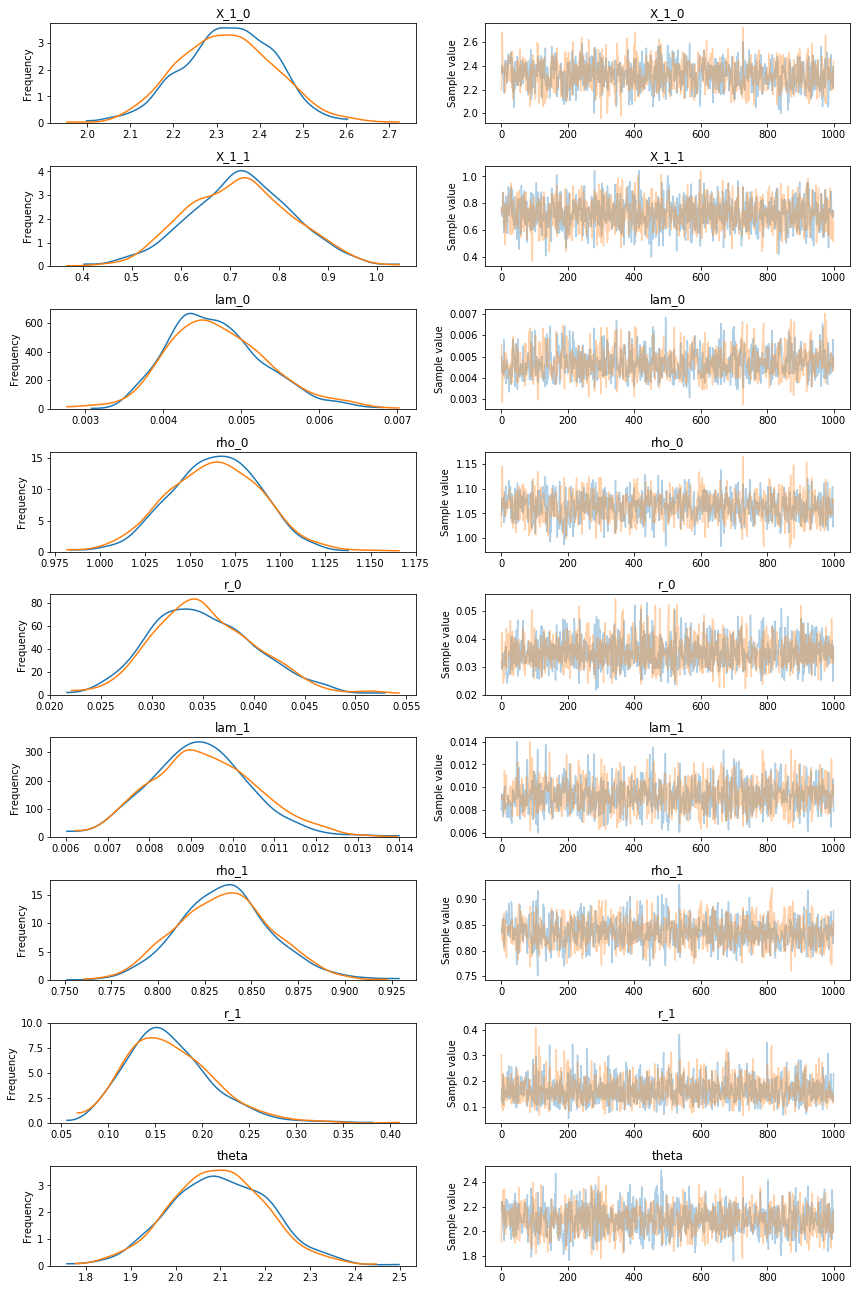

In [11]:
pm.traceplot(trace)

In [ ]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as st

plt.style.use('seaborn-darkgrid')
print('Running with PyMC3 version v.{}'.format(pm.__version__))


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2b53c6d8>,
      dtype=object)

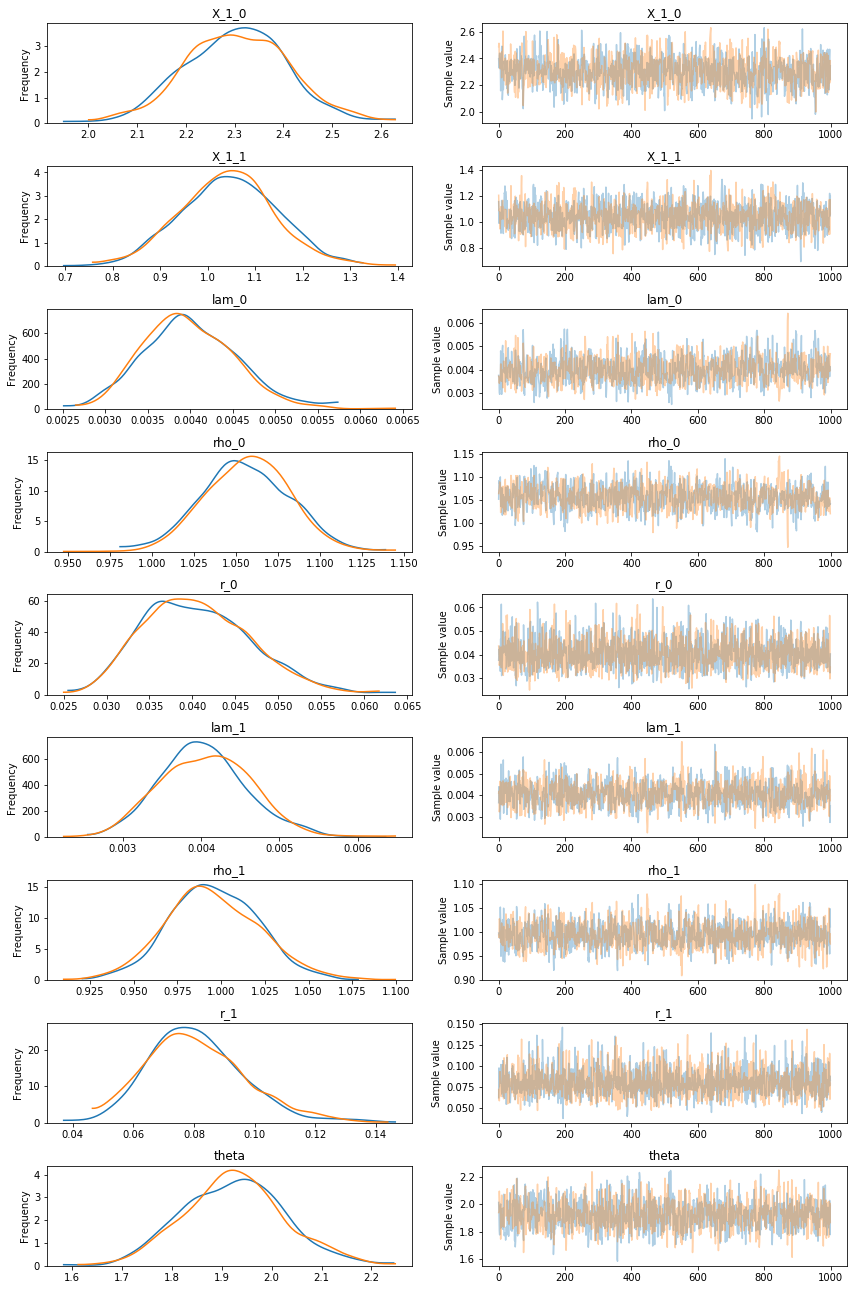

In [19]:
bf.pm.traceplot(trace)

# MINIMAL WORKING EXAMPLE

### Simulate Data 

In [ ]:
N=500; beta = -0.6; rateC = 0.0001;
maxtime = 200
lam =.11; rho = .6
df_sim = bf.simulate.sim_Weibull(N=N, lam =lam, rho = rho, beta = beta, rateC = rateC, maxtime=maxtime)
df_sim.head()


In [ ]:
plt.hist(df_sim.time.values)

In [ ]:
### For now, we will work within the pm.Model() environment. We  will embed this at a later date

In [ ]:
with pm.Model() as mod:
    bf.ParSurv.from_formula(formula='([time],[event])~x', data=df_sim, family="weibull")
    step = pm.NUTS(target_accept=.99)
    trace = pm.sample(10000,step=step,tune =5000)

In [ ]:
pm.traceplot(trace[5000:])

### Multivariate Models

In [6]:
## Frailty 


%matplotlib inline
# Checking it all out
## import packages
import pymc3 as pm
import numpy as np
import pandas as pd
import theano
import theano.tensor as tt
import patsy
from matplotlib import pylab as plt
import scipy as sp
import seaborn as sns
import theano.tensor as tt
from pymc3.model import Model, Deterministic
from pymc3.distributions import Normal, Flat, transforms, Bound, Gamma, InverseGamma
from pymc3.glm.utils import any_to_tensor_and_labels
import warnings
import inspect
import numpy as np
from scipy import special
from pymc3.glm import families
import pymc3.distributions as pm_dists
import patsy
import numbers
import pandas as pd
from copy import copy
import theano.tensor as tt
from pymc3.model import modelcontext
from pymc3 import distributions as pm_dists
FLOAT_EPS = np.finfo(float).eps
import pymc3 as pm
from pymc3.distributions import Continuous, draw_values, generate_samples, Bound, transforms
np.random.seed(34333823)
## First we need to define the arguments from the bash shell from before
## now we pass the seed generated by the particular cluster job id and set it
## throughout the script
#np.random.seed(args.seed)
### FIxed sample size for this simulation
n = 5000
## generate gamma frailty according to parameters \theta^{-1}
theta = .510
## generate gamma frailty term, ~Γ(θ^{-1},θ), np parameterizes with scale, so
### In later versions of this, we merge this within the data generator
## functionalize this
β1 = np.array([0.63, 0.03])
β2 = np.array([0.8, 0.03])
β3 = np.array([0.9, 0.03])
βs = np.vstack([β1,β2,β3])
k=3
λk = np.array([0.0047, 0.0037, 0.0057])
ρk = np.array([0.716, .725, .73])
### Simulate Datasets and Calculate MAPS
## Simulation to see what is going on here

r_true = .5
r_this = .5
def sim_simple_covs(n):
    sex = np.random.binomial(n=1,p=.5,size =n)
    age = np.random.gamma(size=n,  shape = 10, scale = 1/.3)
    return(np.array([sex,age]).T)
X = sim_simple_covs(n)
# Simulate Survival Times, generalize for k categories
def sim_weibull_frail_generalized(betas, theta, X, lam, r, rho, maxtime, cens_end, n, k, first = False):
    '''
    Function to simulate transformed weibull survival times with uniform censoring according to the weibull PH model
    Parameters
    ----------
    betas : effect sizes
    lam : scale parameters for different levels (must be dimension kx1)
    theta : parameter of gamma distribution of frailties
    rho : shape parameters for each level (kx1)
    X : covariates
    maxtime : maximum study time
    r : transformation parameter
    k : number of outcomes
    first : boolean, do we want to return just the time to first event
    '''
    w = np.random.gamma(size = n, shape=theta**(-1), scale = theta)
    ## from probability integral transform
    Te = ((np.exp(-(np.log(np.random.uniform(size=(n,k)))*r)/w[:,None])-1)/(r*lam*np.exp(np.dot(X,betas.T))))**(1/rho)
    # Do we want time to first event r?
    # generate censoring time, unif and truncated by tau
    if first == True:
        Cens = 1+cens_end*np.random.uniform(size = n)
        Cens[Cens>maxtime] = maxtime
        alltimes = np.vstack((Cens,Te.T)).T
        eventType = []
        for i in range(len(w)):
            eventType.append(np.where(alltimes[i,]==np.amin(alltimes[i,]))[0][0])
        obs_t = list(np.amin(alltimes,axis = 1))
        out = pd.DataFrame(np.array([obs_t, eventType, pd.Series(X[:,[0]][:,0]),pd.Series(X[:,[1]][:,0]),w])).T
        # Clean up for the covariates
        out.columns = ["obs_t", "eventType", "sex", "age", "sim_frail"]
    else:
        Cens = 1+cens_end*np.random.uniform(size = (n,k))
        Cens[Cens>maxtime] = maxtime
        results = np.repeat(0, n)
        names_df = ["del"]
        # loop over levels
        for level in range(k):
            obs_t = np.amin(np.array([Te[:,level], Cens[:,level]]).T, axis =1) # observed time
            names_df = np.append(names_df, "time_"+str(level+1))
            delta = (Te[:,level] < Cens[:,level]) + 0 # censoring indicator
            names_df = np.append(names_df, "delta_"+str(level+1))
            results = np.vstack((results, obs_t))
            results = pd.DataFrame(np.vstack((results, delta)))
        # Names of X
        x_names = ["X_"+str(j+1) for j in np.arange(X.shape[1])]
        names_df = np.append(names_df, x_names)
        names_df = np.append(names_df, "frailty") # now add frailty
        out = pd.DataFrame(np.vstack((results, X.T, w.T)).T)
        out.columns = names_df
        out = out.iloc[:, out.columns!="del"] # get rid of extra column
    return(out)
## NOW ACTUALLY GENERATE THE DATA, this is the intitialization step
X = sim_simple_covs(n)
data = sim_weibull_frail_generalized(betas=βs,
                              theta = theta,
                              X = X,
                              lam = λk,
                              rho = ρk,
                              maxtime=200,
                              cens_end = 300,
                              r = r_true ,k=3, first=False, n=n)
### Instantiate the Model outside of the for loop. This reduces the computational
## define tensors with shared variables
# First, generate an instance of data to init the graph
obs_t = np.asarray(data.filter(regex="time"))
        #Now for bayesian Model
δ = np.asarray(data.filter(regex="delta"))

δ2 = np.array([np.append(np.repeat(1, s), np.repeat(0, k-s)).tolist() for s in np.sum(δ, axis = 1)])

# if any events are used
τ = obs_t
# if time to first event is used
#τ = np.tile(np.array([obs_t]).transpose(), (1, 3))
# Design tensor
X_full = theano.shared(X+0.,borrow=True)
#X_t.tag.test_value = np.zeros((n_minibatch, 2))
# event tensor
τ_full = theano.shared(τ+0.,borrow=True)
# Psi tensor
# delta tensor
δ_full = theano.shared(δ+0., borrow = True)
δ2_full = theano.shared(δ2+0., borrow = True)



In [7]:
with pm.Model() as model_test2:
    bf.Frailty.from_formula('([time_1, time_2, time_3],[delta_1, delta_2, delta_3])~X_1+X_2-1', data = data)
    MAP = bf.pm.find_MAP()
    trace = bf.pm.sample(3000, tune =3000, start = MAP)

logp = -34,313, ||grad|| = 63.733: 100%|██████████| 466/466 [00:05<00:00, 80.52it/s] 
  6%|▌         | 371/6000 [05:49<1:28:25,  1.06it/s]/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)



KeyboardInterrupt: 

In [4]:
MAP

{'X_1_0': array(0.63389995),
 'X_1_1': array(0.84235938),
 'X_1_2': array(0.88407187),
 'X_2_0': array(0.02965558),
 'X_2_1': array(0.02954495),
 'X_2_2': array(0.02982321),
 'lam_0': array(0.00492492),
 'lam_0_log__': array(-5.31344694),
 'lam_1': array(0.00368272),
 'lam_1_log__': array(-5.60410295),
 'lam_2': array(0.0062766),
 'lam_2_log__': array(-5.07092701),
 'r_0': array(0.40249722),
 'r_0_log__': array(-0.91006708),
 'r_1': array(0.47768397),
 'r_1_log__': array(-0.73880592),
 'r_2': array(0.45601659),
 'r_2_log__': array(-0.78522608),
 'rho_0': array(0.70394333),
 'rho_0_log__': array(-0.35105743),
 'rho_1': array(0.72083246),
 'rho_1_log__': array(-0.32734854),
 'rho_2': array(0.71421205),
 'rho_2_log__': array(-0.33657537),
 'theta': array(0.50490322),
 'theta_log__': array(-0.68338851)}